In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import sys
sys.path.append('''C:/Users/cayde/Desktop/Research/delay-optimizer''')
import os
import json
from Optimizer_Scripts.learning_rate_generator import generate_learning_rates
from Optimizer_Scripts.param_optimizer_helper import test_builder
from Optimizer_Scripts import Delayer
from Optimizer_Scripts import optimizers 
from Optimizer_Scripts import functions

# Helper Functions

In [2]:
def run_single_start(delayer, x_init, maxiter=1000, tol=1e-5, use_delays=True, D=None, random=True):
    delayer.x_init = x_init
    delayer.compute_time_series(tol=tol, maxiter=maxiter, use_delays=use_delays, random=random, D=D)
    return delayer


def set_axis_attributes(ax, plot_dims):
    for it, (dim_0, dim_1) in enumerate(plot_dims):
        axis = ax[it]
        axis.set_xlabel("Dimension {}".format(dim_0))
        axis.set_ylabel("Dimension {}".format(dim_1))
        axis.set_xlim([-5.,10.])
        axis.set_ylim([-5.,10.])
        
    
def plot_values(axis, value, vmax=25.0, vmin=0.0, time_plot=False, cmap='winter'):
    #plot the results according to the given delayer
    color = 'r'
    if cmap == 'winter':
        color = 'b'
    if vmin > 0:
        vmin = 0
    for i in range(len(value[0])):
        value_2 = value[2][i]
        if (time_plot is True):
            value_2 = np.flip(np.arange(1,len(value_2)+1,1))
            vmin = 0
            vmax = len(value_2)
            axis.plot(value[0][i], value[1][i], color=color, alpha=0.3)
          
        value_0 = value[0][i]
        value_1 = value[1][i]
        im = axis.scatter(value_0, value_1,c=value_2, vmin=vmin, vmax=vmax, alpha=0.01, cmap=cmap, s=100)
    
    return im
    
    
def add_new_values(value, dim_tuple, delayer, type_plot):
    
    # TODO - Change so plots do not connect (a lot of lists as opposed to one list of all values)
    value[0].append(delayer.time_series[1:,dim_tuple[0]].tolist())
    value[1].append(delayer.time_series[1:,dim_tuple[1]].tolist())
    if (type_plot == 'loss'):
        value[2].append(delayer.loss_list)
    elif (type_plot == 'gradient'):
        value[2].append(delayer.grad_list)
    max_val = max(max(value[2]))
    min_val = min(min(value[2]))
    return value, max_val, min_val 

    
def create_grid(range_grid, num_points, n):
    x = np.linspace(range_grid[0], range_grid[1], num_points)
    #create the mesh
    list_xs = [x for i in range(n)]
    grid = itertools.product(*list_xs)
    return grid


def plot_colorbar(fig, axis, image):
    colorbar = fig.colorbar(image, ax=axis)
    colorbar.set_alpha(1)
    colorbar.draw_all()
    

def plot_results(plot_dims, values, vmax, vmin, final_losses, final_states, fig, ax, colorbar=True, use_both=False, time_plot=False):
    #now plot on each axis in the list of axes
    alpha_hist = 1.0
    final_del_losses = None
    final_del_states = None
    if (use_both is True):
        values, values_del = values
        vmax, vmax_del = vmax
        vmin, vmin_del = vmin
        final_losses, final_del_losses = final_losses
        final_states, final_del_states = final_states
        final_del_states = np.ravel(np.asarray(final_del_states))
        alpha_hist = 0.3
        
    for it in range(len(plot_dims)):
        axis = ax[it]
        bins=25
        #plot the other plot if use both is true
        if (use_both is True):
            im1 = plot_values(axis, values_del[it], vmax=vmax_del, vmin=vmin_del, cmap='autumn', time_plot=time_plot) 
            bins=3
        im = plot_values(axis, values[it], vmax=vmax, vmin=vmin, time_plot=time_plot)
        if (colorbar is True):
            plot_colorbar(fig, axis, im)
    final_states = np.ravel(np.asarray(final_states))
    ax[-2].hist(final_states, alpha=alpha_hist, color='b',bins=bins)
    ax[-2].set_title("Final State Values")
    ax[-1].hist(final_losses, alpha=alpha_hist, color='b',bins=bins)
    ax[-1].set_title("Final Loss Values")
    #plot the delayed finals if we did both
    if final_del_losses is not None:
        ax[-2].hist(final_del_states, alpha=alpha_hist, color='r',bins=bins)
        ax[-1].hist(final_del_losses, alpha=alpha_hist, color='r',bins=bins)

        
def calculate_save_values(delayer, initials, plot_dims, maxiter, tol, use_delays, gen_params, type_plot,
                         random=True, D=None):
    #plot the results according to the given dimensions
    values = [[[], [], []] for i in range(len(plot_dims))]
    final_losses = list()
    final_states = list()
    total_min = np.inf
    total_max = -np.inf
    #get the relevant variables from the delayer
    loss, grad, params, n = delayer.loss_function, delayer.grad, delayer.Optimizer.params, delayer.n
    max_L, num_delays = delayer.max_L, delayer.num_delays
    for x_init in initials:
        x_init = np.asarray(x_init)
        delayer = run_single_start(delayer, x_init, maxiter, tol, use_delays, random=random, D=D)
        for it in range(len(values)):
            dim_tuple = plot_dims[it]
            value = values[it]
            values[it], max_val, min_val = add_new_values(value, dim_tuple, delayer, type_plot)
            if (max_val > total_max):
                total_max = max_val
            if (min_val < total_min):
                total_min = min_val
        final_losses.append(delayer.final_val)
        final_states.append(delayer.final_state)
        #recreate the delayer to reset the learning rate generater
        del delayer
        params['learning_rate'] = generate_learning_rates(False, gen_params)
        optim = optimizers.Adam(params)
        delayer = Delayer.Delayer(n, optim, loss, grad, max_L=max_L, 
                                  num_delays=num_delays, compute_loss=True,
                                  save_grad=True)
    return values, final_losses, final_states, max_val, min_val, delayer

        
def initialize_optimizer(optimizer='Adam', loss='Rosenbrock', n=2, max_L=1, num_delays=1000, uncoupled=False):
    #get the loss and gradients
    loss=functions.rosenbrock_gen(n, uncoupled=uncoupled)
    grad=functions.rosen_deriv_gen(n, uncoupled=uncoupled)
    #create the optimizer
    max_L=max_L
    num_delays=num_delays
    params=dict()
    params['beta_1'] = 0.9
    params['beta_2'] = 0.999
    gen_params = {'step_size': 740, 'min_learning_rate': 0.23, 'max_learning_rate': 2.98}
    params['learning_rate'] = generate_learning_rates(False, gen_params)
    optim = optimizers.Adam(params)
    delayer = Delayer.Delayer(n, optim, loss, grad, max_L=max_L, 
                              num_delays=num_delays, compute_loss=True,
                              save_grad=True)
    return delayer, gen_params
    
    
def optimizer_path_tracker(range_grid=[-5.,10.], num_points=100, maxiter=2000, tol=1e-5,
                use_delays=True, n=1000, plot_dims=[(0,1),(2,3), (92,93), (84,85)], type_test='random',
                do_both=False, num_delays=1000, max_L=1, type_plot='loss', colorbar=True, time_plot=False,
                random=True, D=None, uncoupled=False):
    #the different types of initial values
    if type_test == 'random':
        initials = np.random.uniform(range_grid[0], range_grid[1], size=(num_points,n))
    elif type_test == 'grid':
        initials = create_grid(range_grid, num_points, n)
    elif type_test == 'same':
        initials = np.random.uniform(range_grid[0], range_grid[1], size=n)
        initials = np.tile(initials, (num_points, 1))
    #initalize optimizer and parameters
    delayer, gen_params = initialize_optimizer(n=n, max_L=max_L, num_delays=num_delays, uncoupled=uncoupled)
    #plot the results on a loss/dimension scatter plot
    title = "{}: {} Optimizer: {} Dimensions: {} is max delay".format('Rosenbrock', delayer.Optimizer.name, delayer.n, delayer.max_L)
    fig,ax=plt.subplots(len(plot_dims)+2,1,figsize=(10,8*(len(plot_dims)+2)))
    #now make ax a list if it is not already
    if type(ax) is not np.ndarray:
        ax = np.array([ax])
    #set the labels on the axes
    set_axis_attributes(ax,plot_dims)
    #calculate the relavant values
    if (do_both is False):
        values, final_losses, final_states, vmax, vmin, delayer = calculate_save_values(delayer, initials, plot_dims, 
                                                                                        maxiter, tol, use_delays, 
                                                                                        gen_params, type_plot,
                                                                                        random, D)
    else:
        values_del, final_del_losses, final_del_states, vmax_del, vmin_del, delayer = calculate_save_values(delayer, initials, 
                                                                                                            plot_dims, maxiter, 
                                                                                                            tol, True, gen_params, 
                                                                                                            type_plot, random, D)
        values, final_losses, final_states, vmax, vmin, delayer = calculate_save_values(delayer, initials, plot_dims, 
                                                                                        maxiter, tol, False, gen_params, 
                                                                                        type_plot, random, D)
        values, final_losses, final_states, vmax, vmin = ((values, values_del), (final_losses, final_del_losses), 
                                                         (final_states, final_del_states), (vmax, vmax_del), 
                                                         (vmin, vmin_del))
        
    del delayer
    plot_results(plot_dims, values, vmax, vmin, final_losses, final_states, fig, ax, colorbar=colorbar, 
                 use_both=do_both, time_plot=time_plot)
    fig.suptitle(title)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    plt.show()

#  2 Dimensional Grid Loss Test

### Undelayed Optimal Parameters Test

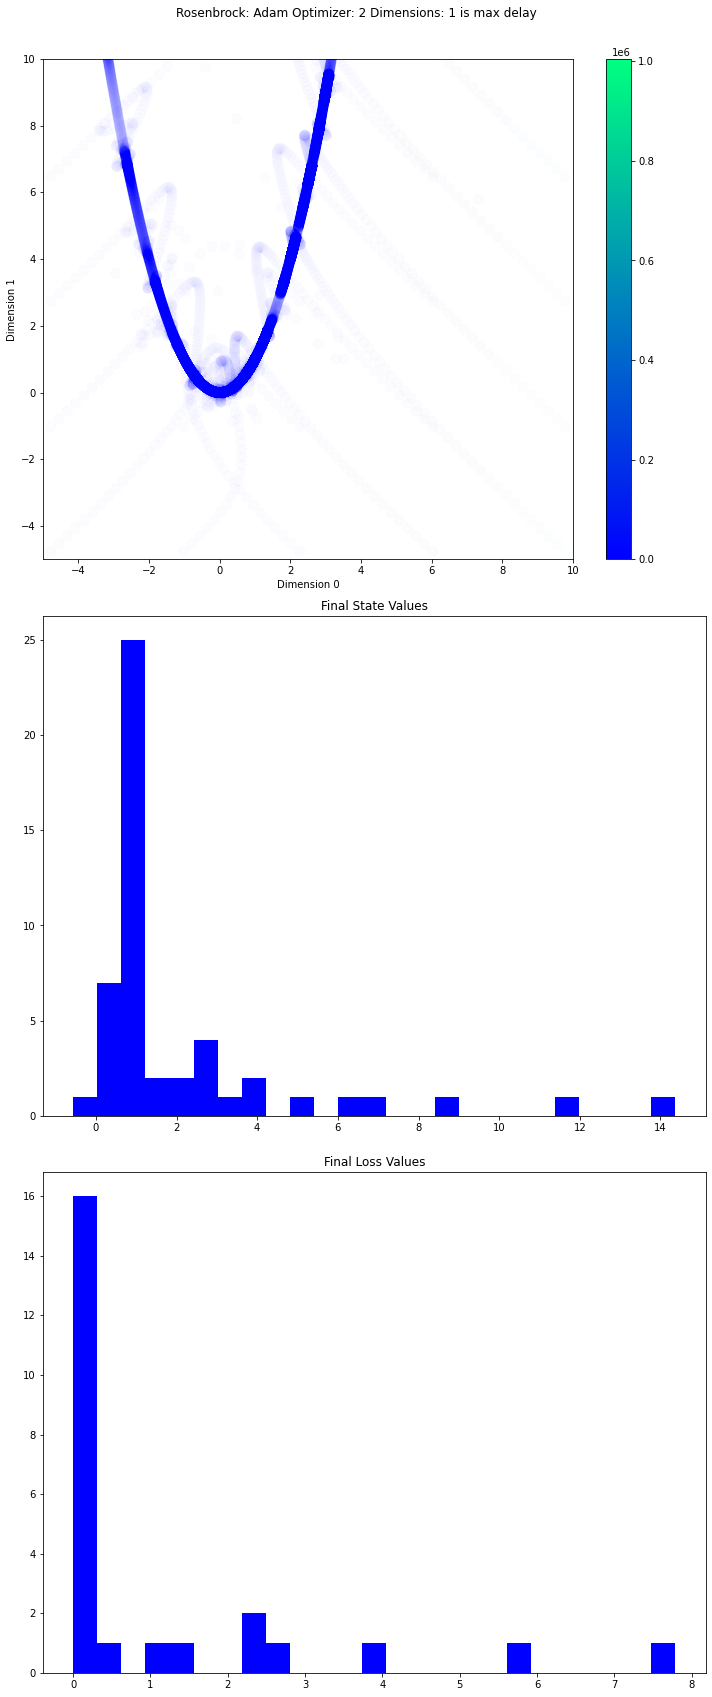

In [3]:
optimizer_path_tracker(num_points=5, use_delays=False, plot_dims=[(0,1)], type_test='grid', n=2)

### Delayed Optimal Parameters Test

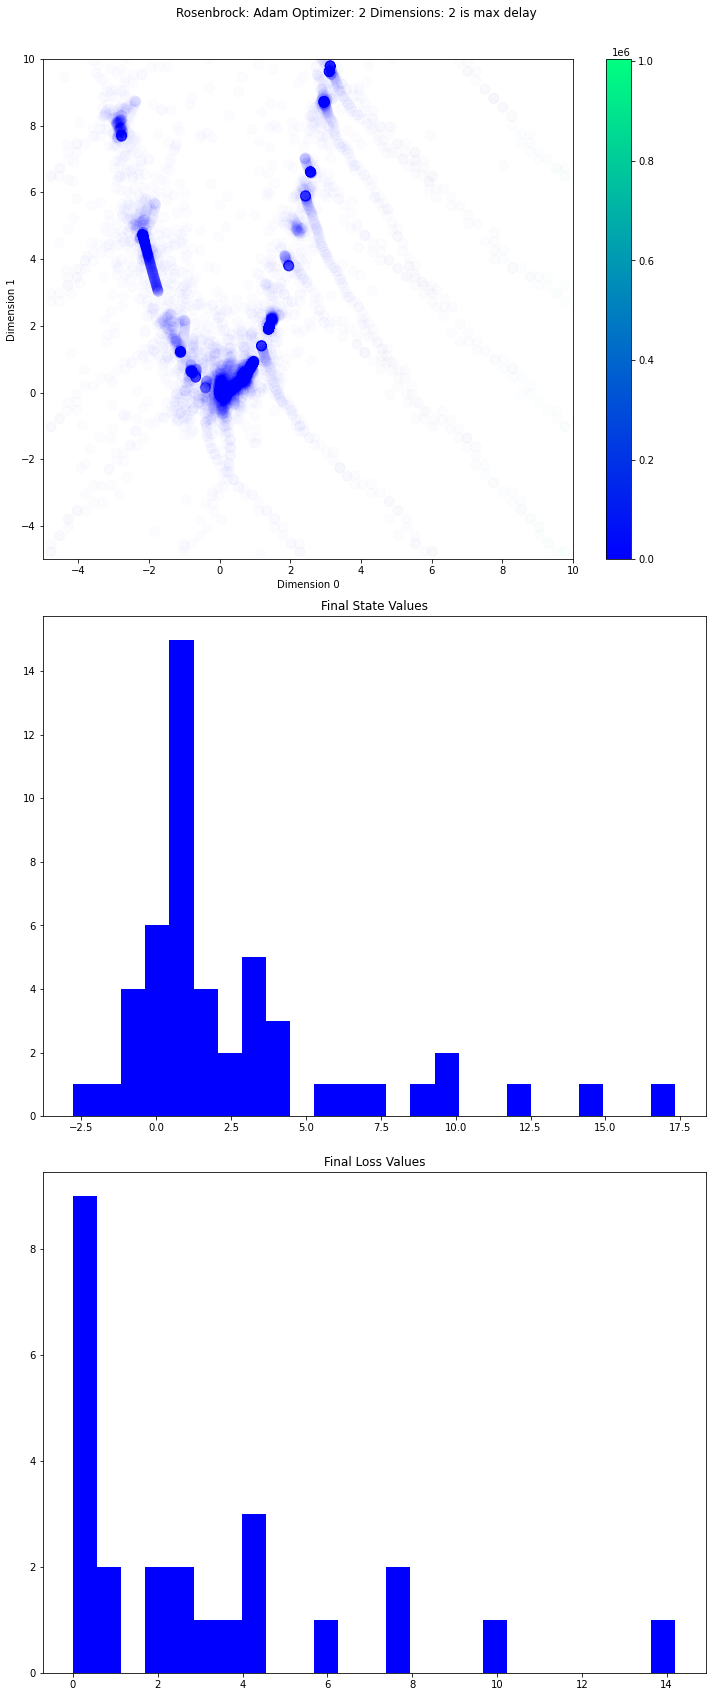

In [4]:
optimizer_path_tracker(num_points=5, use_delays=True, plot_dims=[(0,1)], type_test='grid', n=2, max_L=2)

# 1000 Dimensional Loss Test - Randomly Generated Initial Points

### Undelayed Coupled Rosenbrock

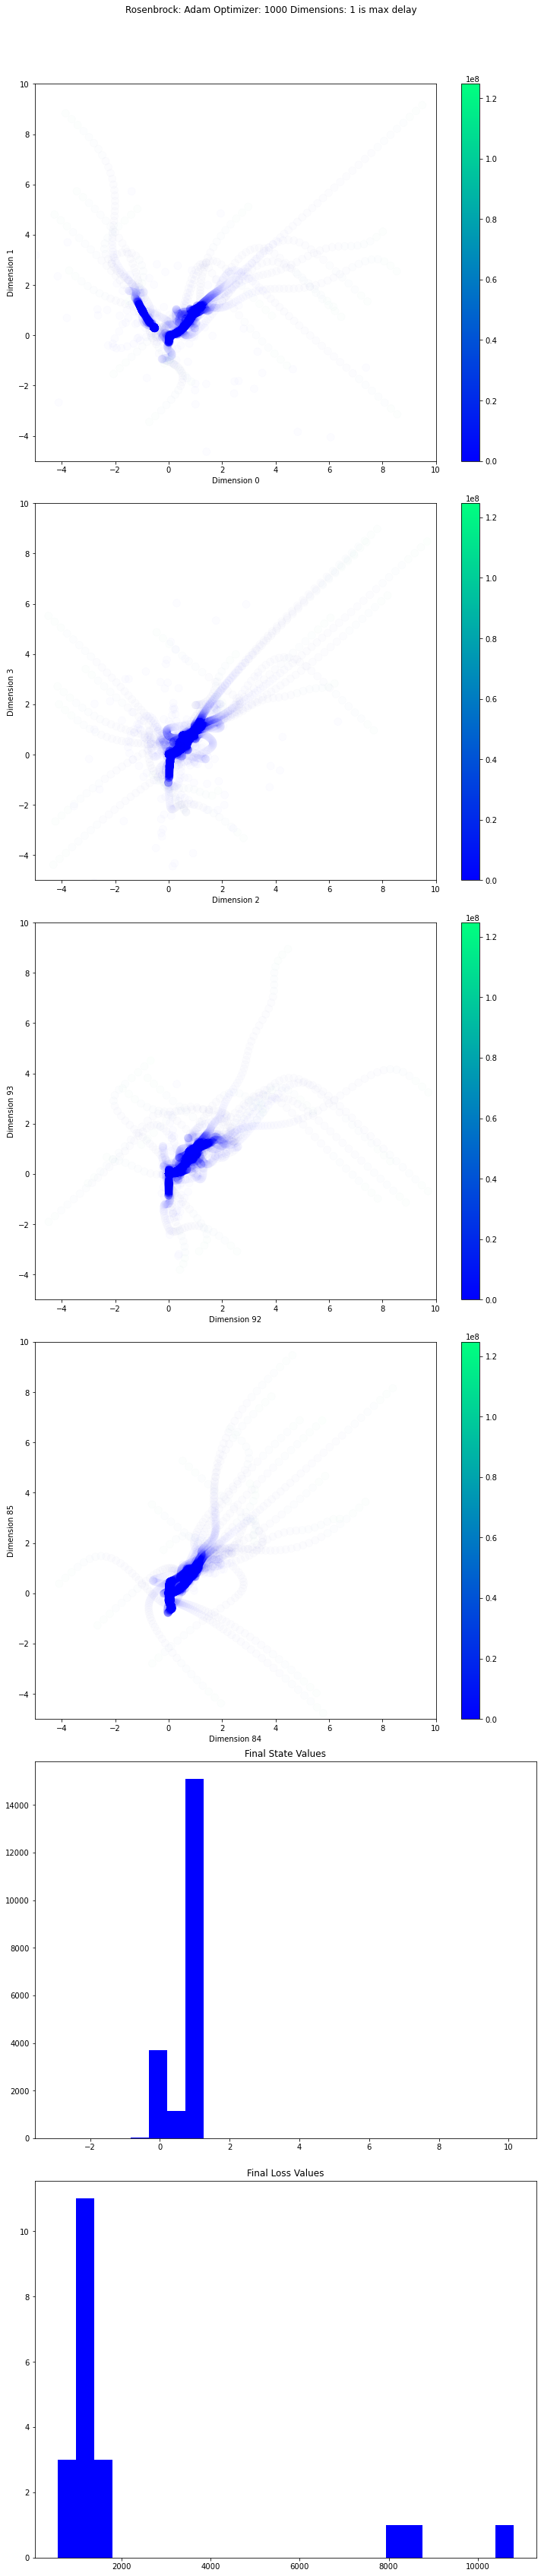

In [5]:
optimizer_path_tracker(num_points=20, use_delays=False, type_test='random', n=1000, uncoupled=False)

### Delayed Coupled Rosenbrock

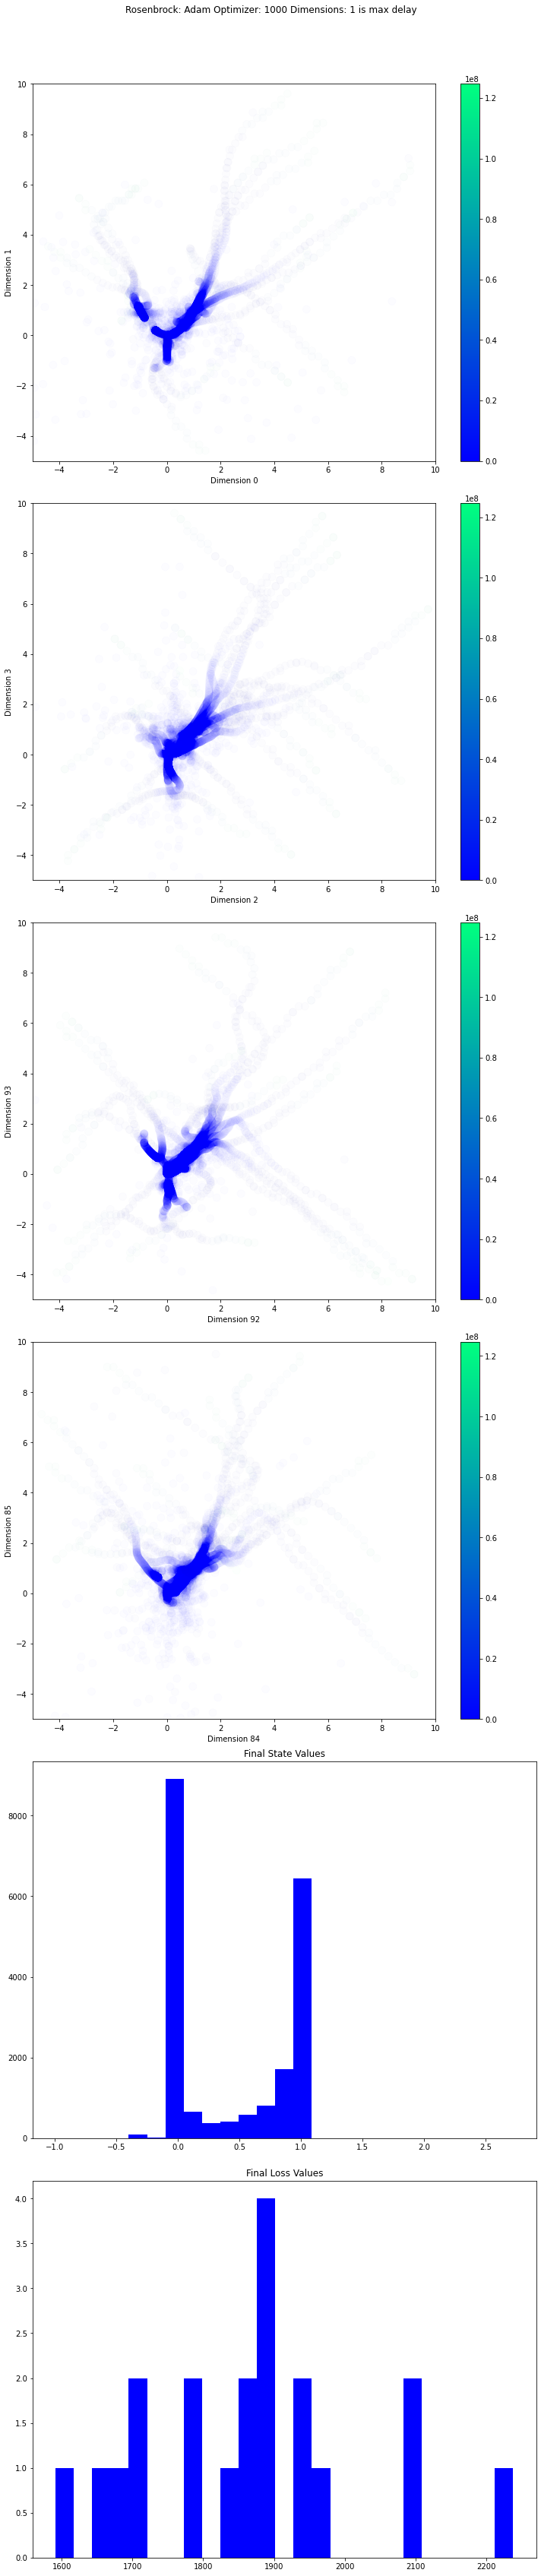

In [6]:
optimizer_path_tracker(num_points=20, use_delays=True, type_test='random', n=1000)

### Undelayed Uncoupled Rosenbrock

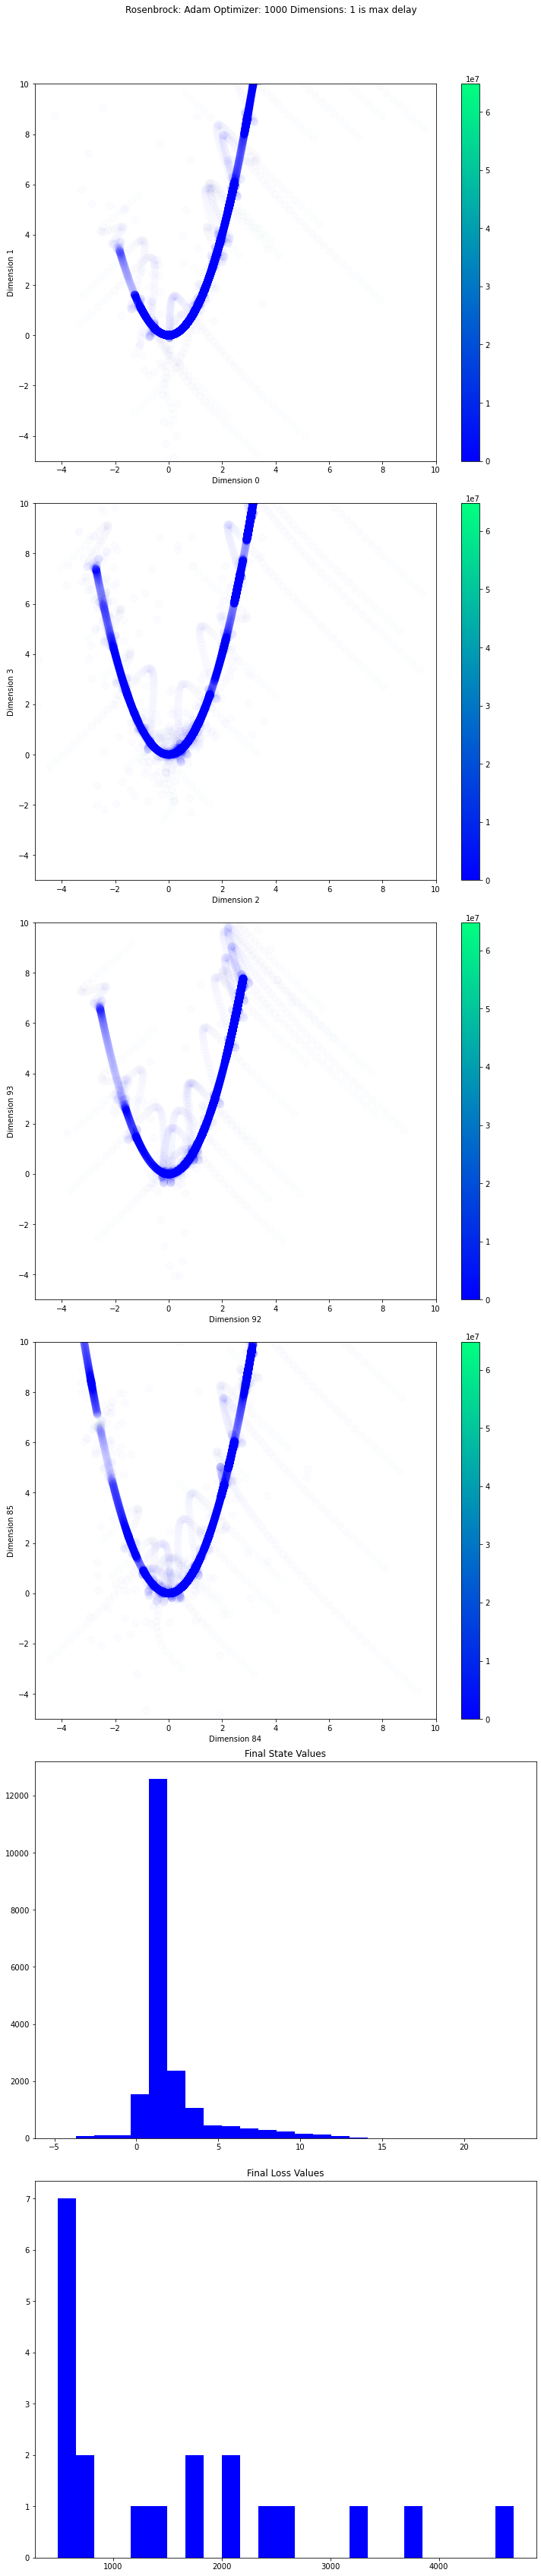

In [7]:
optimizer_path_tracker(num_points=20, use_delays=False, type_test='random', n=1000, uncoupled=True)

### Delayed Uncoupled Rosenbrock

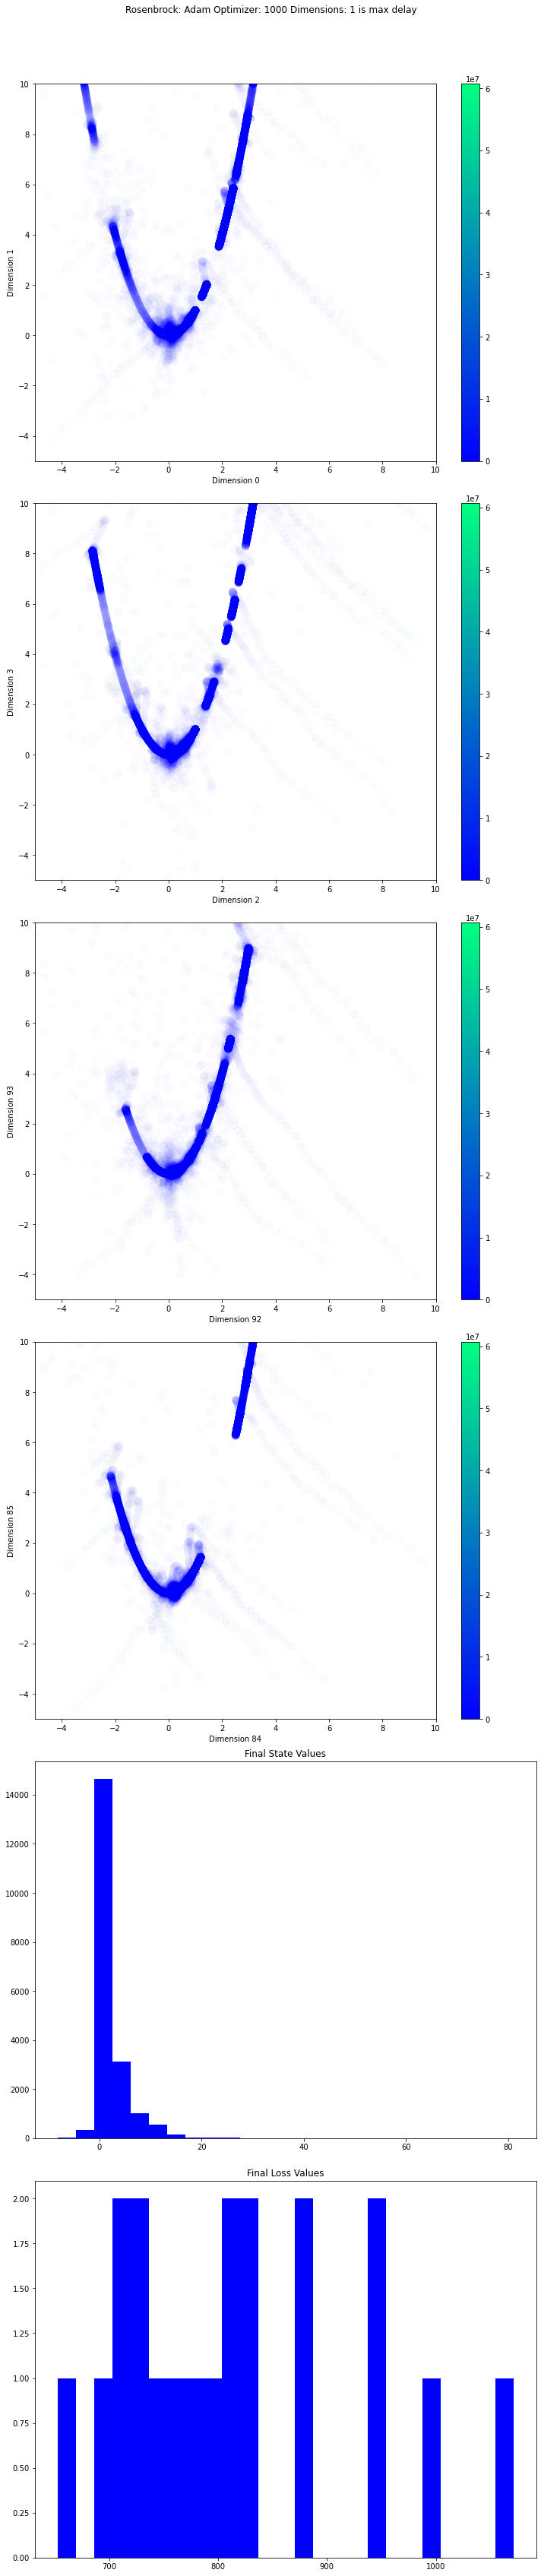

In [8]:
optimizer_path_tracker(num_points=20, use_delays=True, type_test='random', n=1000, uncoupled=True)

# 10000 Dimensional Loss Test

### Undelayed - Coupled Rosenbrock

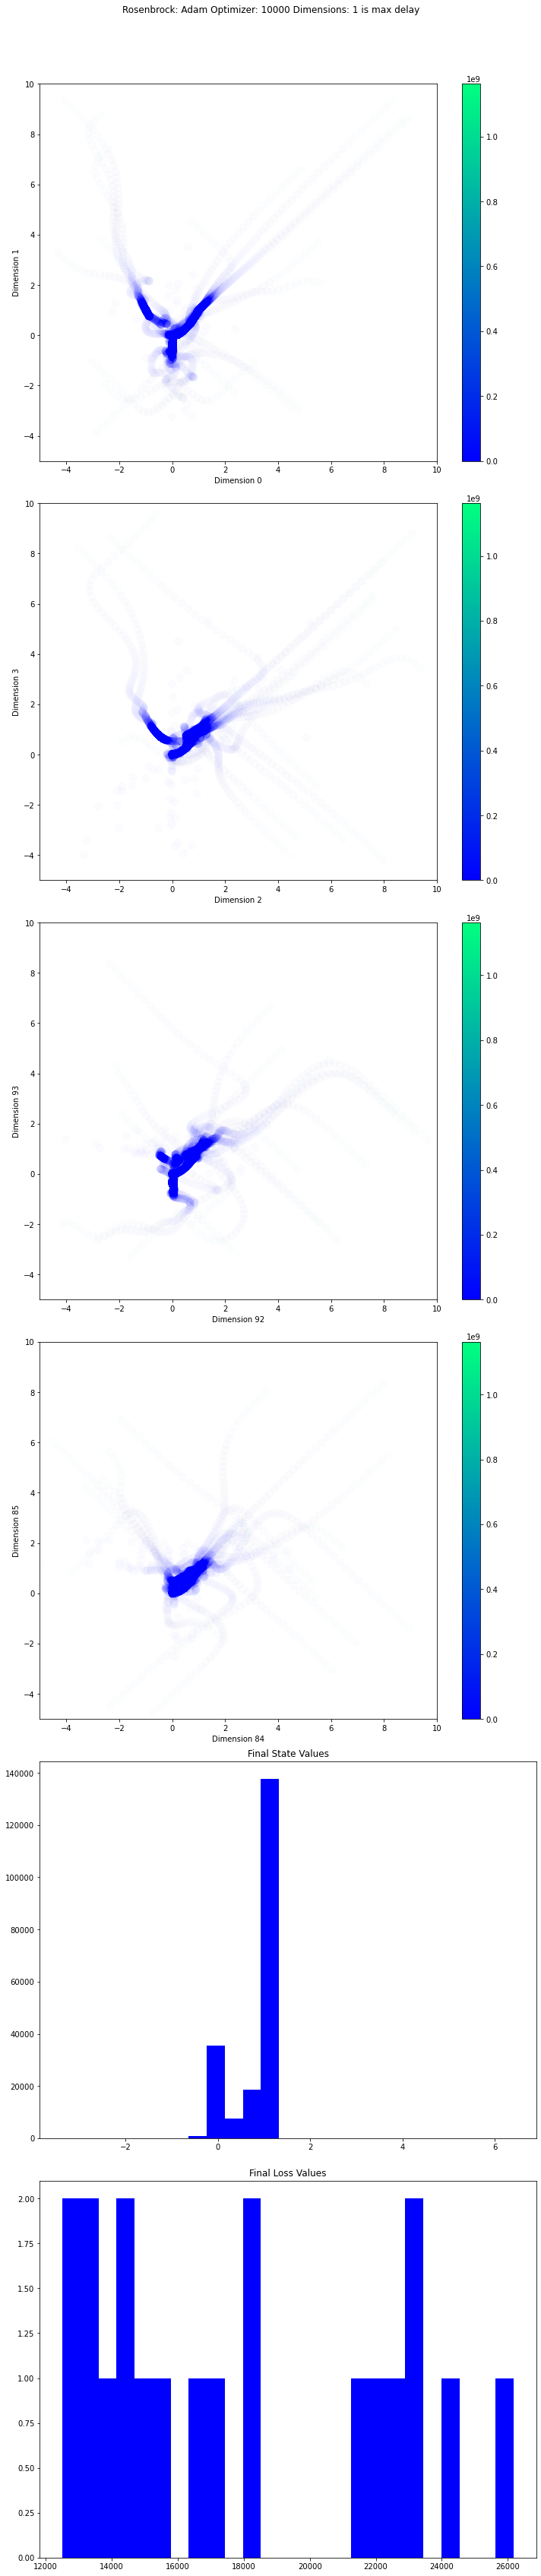

In [9]:
optimizer_path_tracker(num_points=20, use_delays=False, type_test='random', n=10000)

### Delayed - Coupled Rosenbrock

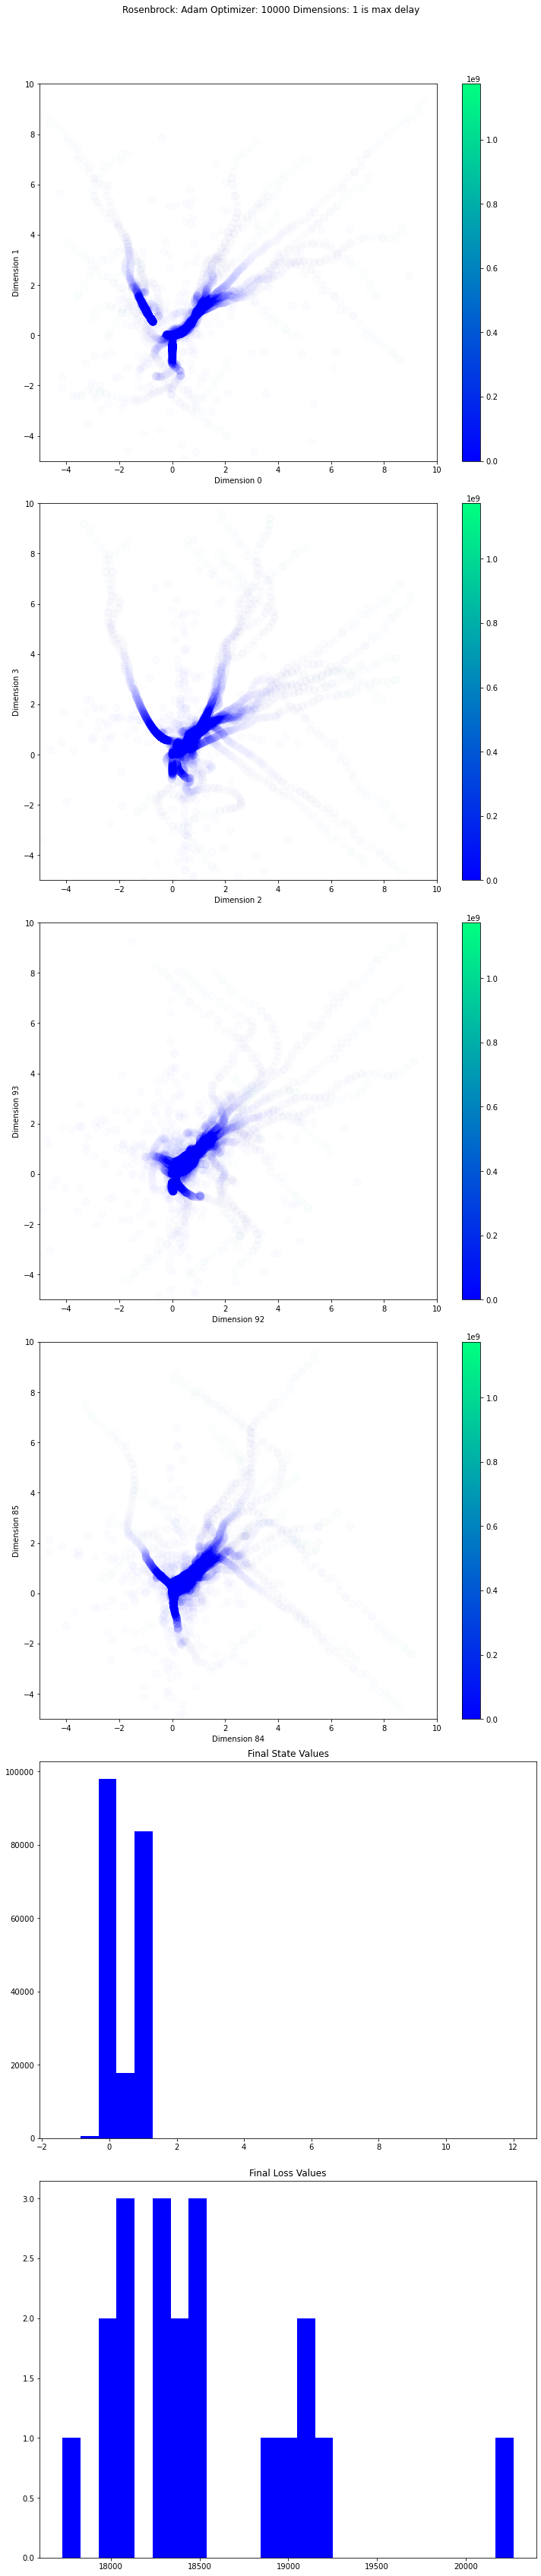

In [10]:
optimizer_path_tracker(num_points=20, use_delays=True, type_test='random', n=10000)

### Undelayed - Uncoupled Rosenbrock

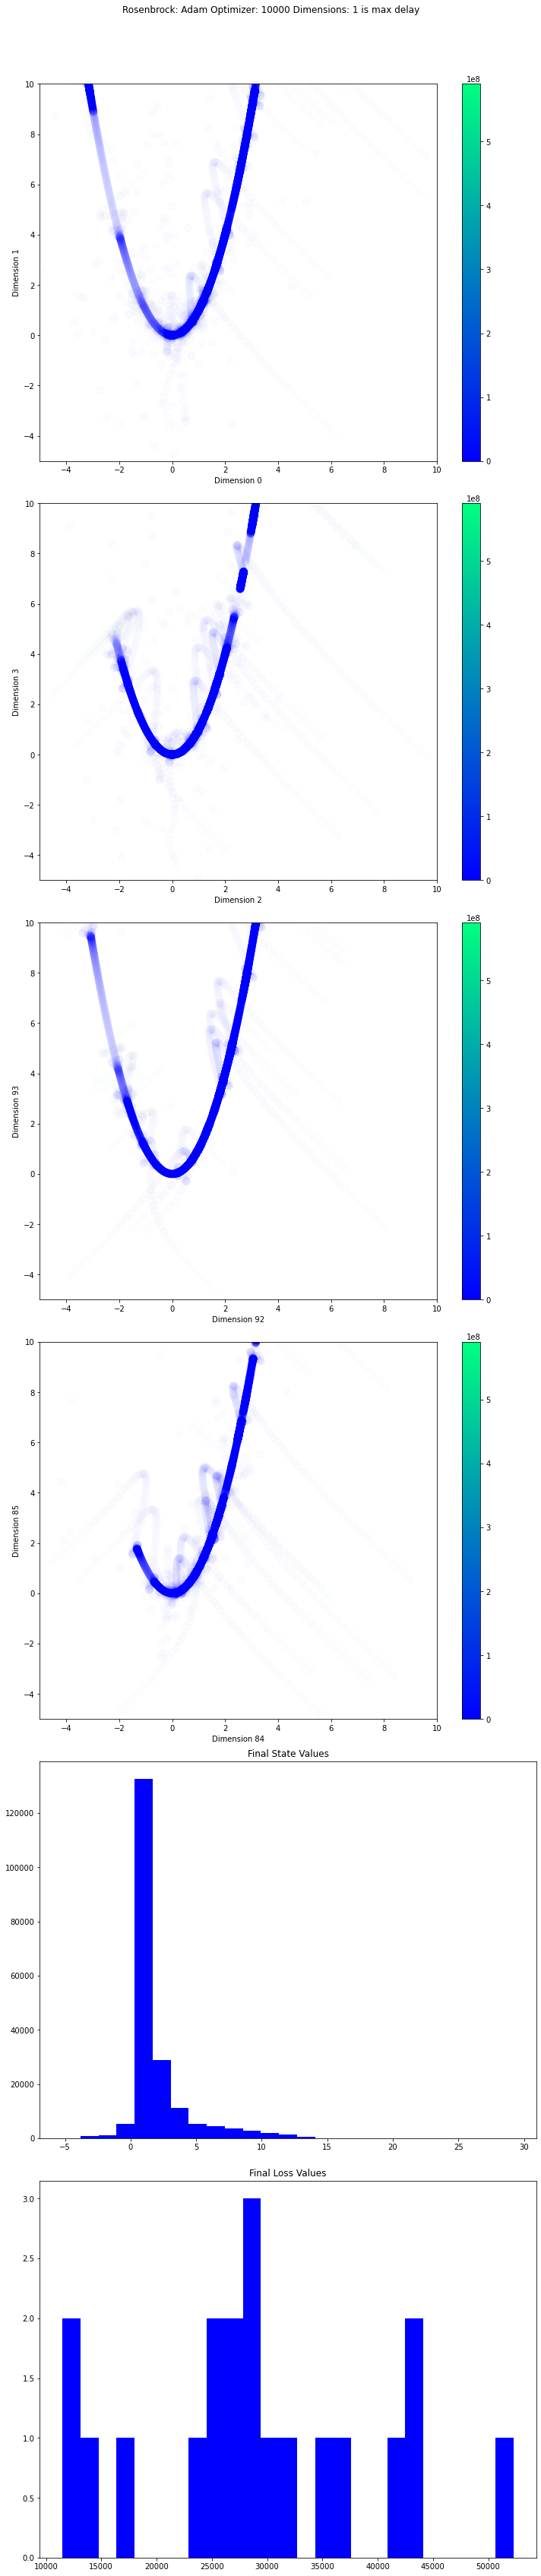

In [11]:
optimizer_path_tracker(num_points=20, use_delays=False, type_test='random', n=10000, uncoupled=True)

### Delayed - Uncoupled Rosenbrock

In [ ]:
optimizer_path_tracker(num_points=20, use_delays=True, type_test='random', n=10000, uncoupled=True)

# 2 Dimensions Grid Gradient

### Undelayed - Grid

In [ ]:
optimizer_path_tracker(num_points=5, use_delays=False, plot_dims=[(0,1)], type_test='grid', n=2, type_plot='gradient')

### Undelayed - Random

In [ ]:
optimizer_path_tracker(num_points=20, use_delays=False, plot_dims=[(0,1)], type_test='random', n=2, type_plot='gradient')

### Delayed - Grid

In [ ]:
optimizer_path_tracker(num_points=5, use_delays=True, plot_dims=[(0,1)], type_test='grid', n=2, type_plot='gradient')

### Delayed - Random

In [ ]:
optimizer_path_tracker(num_points=20, use_delays=True, plot_dims=[(0,1)], type_test='random', n=2, type_plot='gradient')

# Plots Over Time Test

In [ ]:
optimizer_path_tracker(num_points=1, do_both=True, plot_dims=[(0,1)], type_test='random', n=2, type_plot='loss', colorbar=False, time_plot=True)

In [ ]:
optimizer_path_tracker(num_points=1, do_both=True, type_test='random', n=1000, type_plot='loss', colorbar=False, time_plot=True)

In [ ]:
optimizer_path_tracker(num_points=50, do_both=False, type_test='same', n=1000, type_plot='loss', colorbar=False, time_plot=True)

# 2d delay in 1 dimension Test

In [ ]:
D = [np.array([1,0])]
optimizer_path_tracker(num_points=50, do_both=True, plot_dims=[(0,1)], type_test='random', n=2, type_plot='loss', colorbar=False, time_plot=False, random=False, D=D)

# 2d delay in both dimensions Test

In [ ]:
D = [np.array([1,1])]
optimizer_path_tracker(num_points=1, do_both=True, plot_dims=[(0,1)], type_test='random', n=2, type_plot='loss', colorbar=False, time_plot=True, random=False, D=D)

# 1000 Dimensions Test

In [ ]:
D_s = np.zeros(1000,dtype=int)
D_s[0:100] = 1
D = [D_s]
optimizer_path_tracker(num_points=1, do_both=True, type_test='random', n=1000, type_plot='loss', colorbar=False, time_plot=True, random=False, D=D)

In [ ]:
D_s = np.zeros(1000,dtype=int)
D_s[0:500] = 1
D = [D_s]
optimizer_path_tracker(num_points=1, do_both=True, type_test='random', n=1000, type_plot='loss', colorbar=False, time_plot=True, random=False, D=D)

In [ ]:
D_s = np.zeros(1000,dtype=int)
D_s[:950] = 1
D = [D_s]
optimizer_path_tracker(num_points=1, do_both=True, type_test='random', n=1000, type_plot='loss', colorbar=False, time_plot=True, random=False, D=D)

In [ ]:
D_s = np.ones(1000,dtype=int)
D = [D_s]
optimizer_path_tracker(num_points=5, do_both=True, type_test='random', n=1000, type_plot='loss', colorbar=False, time_plot=True, random=False, D=D)